In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
from src.data import load_characters, load_movies
from src.utils.helpers import (
    filter_by_country, 
    drop_nans, 
    fix_date, 
    filter_by_language, 
    merge_movies_and_actors
)

characters = load_characters()
characters = drop_nans(characters, column="FreebaseActorId")


movies = load_movies()

us_movies = filter_by_country(movies, country="United States of America")
print("Number of US movies:", us_movies.shape[0])


us_movies = drop_nans(us_movies, column="Revenue")
us_movies = drop_nans(us_movies, column="ReleaseDate")
us_movies = fix_date(us_movies, column="ReleaseDate")
print("Number of US movies after dropping Nans:", us_movies.shape[0])

us_movies = filter_by_language(us_movies, language="English Language")
us_characters_movies = merge_movies_and_actors(us_movies, characters)

Number of US movies: 34408
Number of US movies after dropping Nans: 6923


In [6]:
import networkx as nx
from src.utils.helpers import create_graph_from_data

G_US = create_graph_from_data(us_characters_movies)
print(f"Number of vertices: {len(G_US.nodes)}, number of edges: {len(G_US.edges)}")

Number of vertices: 30378, number of edges: 613672


#### Testing whether the biggest communities are stable

The result of the Louvian algorithm depends on the seed it is initialized with.
We will try to determine whether generated communities depend on the seed we use. To do that, we will consider multiple runs with $5$ different seeds.

For each ordered pair of runs we will match the communities of the first run to the communities of the second run. The matching procedure works like this:

Go over all communities in the run in the decreasing size order
1. For each community in the loop determine the community of the second run with the biggest intersection that wasn't yet picked
2. Mark the found community from the second run as picked

Using the information about matched communities, we will build a _matching graph_, where nodes will be of the form $(i;j)$, where $i$ is the number of the run and $j$ is the community, we will draw a directed edge between $(i_{1};j_{1})$ and $(i_{2};j_{2})$ if the first node is matched to the second one and the fraction of actors present in $(i_{1};j_{1})$ that is also present in $(i_{2};j_{2})$ is at least $0.8$. On the edge in the plot we will write this number.

If all the seeds produced the same result, we would get a set of complete graphs of the form $\{(0;i), (1;i), \ldots, (5;i) \}$. But because different seeds produce different results, the subgraphs might be not complete. To determine stable communities, we will be looking for connected components that are "close to completeness": they will have many edges between vertices.

In [686]:
from src.utils.q_4_5.helpers import read_community_list

communities_US_list = []
actor_id_to_community_list = []

read_community_list(G_US, communities_US_list, actor_id_to_community_list)

Matching graph of the largest $10$ communities

In [689]:
from src.utils.q_4_5.helpers import generate_graph

G = generate_graph(communities_US_list, actor_id_to_community_list, 10)

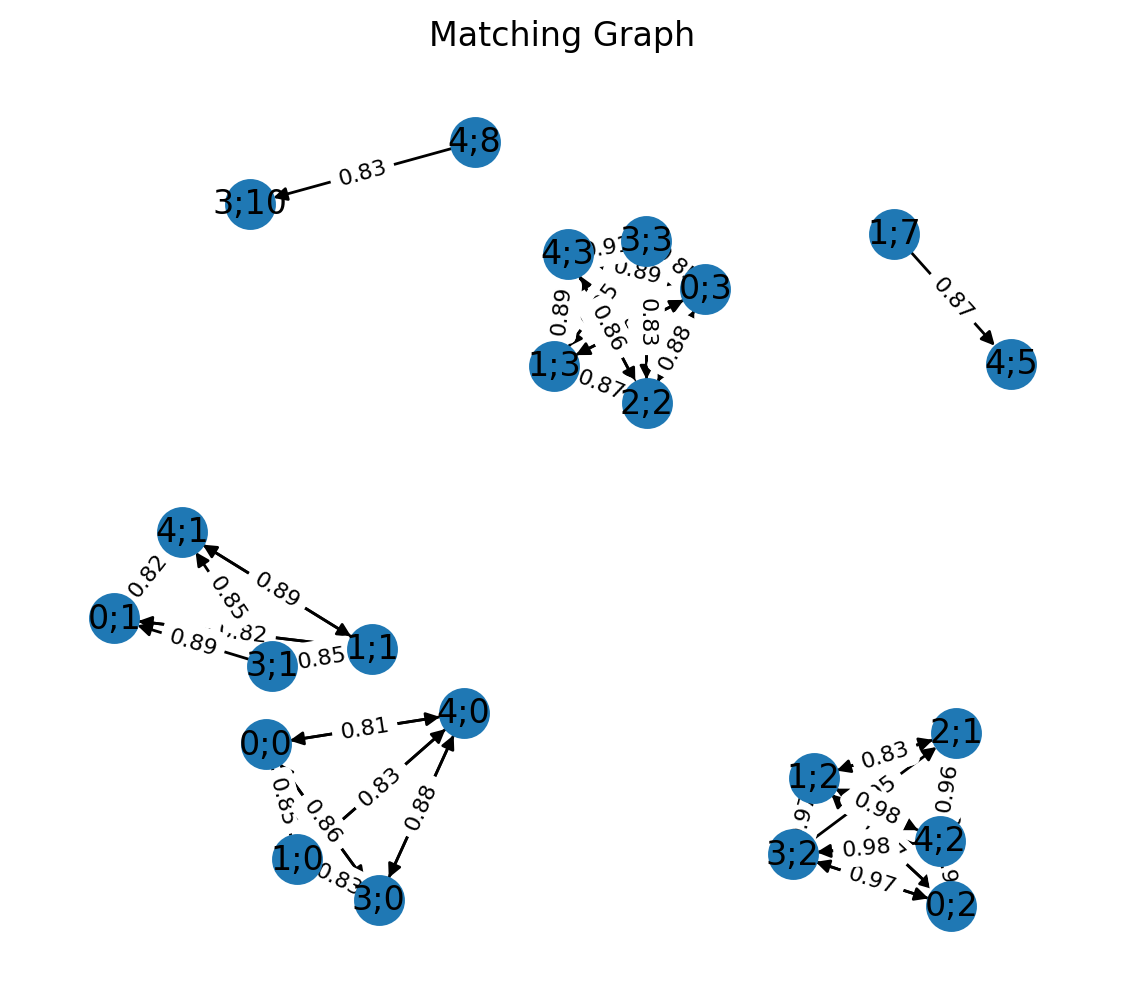

In [690]:
from src.utils.q_4_5.helpers import draw_G

draw_G(G, k=0.5, iterations=30, seed=12)

We see that from the first 10 largest communities, only the first four (communities $0, 1, 2, 3$) are well grouped together. The indexing for communities $2$ and $3$ is not consistent (for example, we map $(0;2)$ to $(1;2)$).

We hypothize that this consistency means that actors in these communities have a lot in common

#### Analyzing movies of large communities

In [691]:
from src.utils.actors import Cluster

stable_communities = [
    Cluster(characters, us_movies, communities_US_list[0][0]),
    Cluster(characters, us_movies, communities_US_list[0][1]),
    Cluster(characters, us_movies, communities_US_list[0][2]),
    Cluster(characters, us_movies, communities_US_list[0][3])
]

whole_us_industry = Cluster(characters, us_movies, [a for c in communities_US_list[0] for a in c])

Let's find the most popular genres for each of the top communities.
In this section we will say that the film belongs to a cluster if at least half of the cast is in this cluster. This way each film will belong to at most one cluster.

In [693]:
from src.utils.q_4_5.helpers import cluster_most_popular_genres

for i, community in enumerate(stable_communities):
    print(f"For community {i} the top-3 genres are: {cluster_most_popular_genres(community)}")

For community 0 the top-3 genres are: [('Drama', 2333), ('Comedy', 2123), ('Thriller', 1363)]
For community 1 the top-3 genres are: [('Comedy', 1826), ('Drama', 1817), ('Thriller', 1032)]
For community 2 the top-3 genres are: [('Drama', 1117), ('Comedy', 859), ('Romance Film', 590)]
For community 3 the top-3 genres are: [('Drama', 1459), ('Comedy', 957), ('Thriller', 923)]


We see that the second one is a bit more about about comedy and the third one has more romance than thriller

In [694]:
us_num_actors_in_movie = dict(us_characters_movies.groupby("WikipediaId").size()) 

for i, community in enumerate(stable_communities):
    top_revenue_movies = community.cluster_movies(select_type="half", num_actors_in_movie=us_num_actors_in_movie).sort_values(by="Revenue", ascending=False)["MovieName"].head(30)
    print(f"For community {i}, the top grossing movies are: {top_revenue_movies.to_list()}")


For community 0, the top grossing movies are: ['Titanic', 'Toy Story 3', 'The Lion King', 'Finding Nemo', 'Jurassic Park', 'Independence Day', 'E.T. the Extra-Terrestrial', 'Up', 'Forrest Gump', 'Men in Black', 'The Simpsons Movie', 'Monsters, Inc.', 'Terminator 2: Judgment Day', 'Ghost', 'Aladdin', 'Toy Story 2', 'Home Alone', 'Pretty Woman', 'Tarzan', 'Mrs. Doubtfire', 'Beauty and the Beast', 'Dances with Wolves', 'Batman', 'The Bodyguard', 'Grease', 'Back to the Future', 'Godzilla', 'The Fugitive', 'Jurassic Park III', 'My Big Fat Greek Wedding']
For community 1, the top grossing movies are: ['Avatar', 'Shrek 2', 'Spider-Man 3', 'Ice Age: Dawn of the Dinosaurs', 'Ice Age: Continental Drift', 'Spider-Man', 'Shrek the Third', 'Spider-Man 2', 'Shrek Forever After', 'The Amazing Spider-Man', "Madagascar 3: Europe's Most Wanted", 'Mission: Impossible – Ghost Protocol', 'The Hunger Games', 'Ice Age: The Meltdown', 'Fast Five', 'Hancock', 'Men in Black 3', 'Iron Man 2', 'Madagascar: Escape

We see that if movies make up a series (like with Shrek, which has Shrek, Shrek 2, Shrek the Third, $\ldots$), then all the movies belong to one cluster. This is expected, because the movies in a series have similar casts.
Example of series from the highest-grossing movies:
- Community 0: Toy Story, Jurassic Park
- Community 1: Shrek, Spider-Man, Ice Age
- Community 2: - (films in this community are a bit more "romantic" as we have seen in the genre analysis and they don't tend to have continuations)
- Community 3: Harry Potter, The Lord of the Rings, The Dark Knight

#### Analyzing movies of smaller stable communities

Now let's consider smaller communities as well, we expect the connections in the matching graph to be rarer. But in case there are any, we expect to have some specific property in this smaller cluster which makes it being selected in a separate cluster in multiple runs

In [706]:
G_bigger_range = generate_graph(communities_US_list, actor_id_to_community_list, 30, generate_from_and_to=0, starting_position=10)

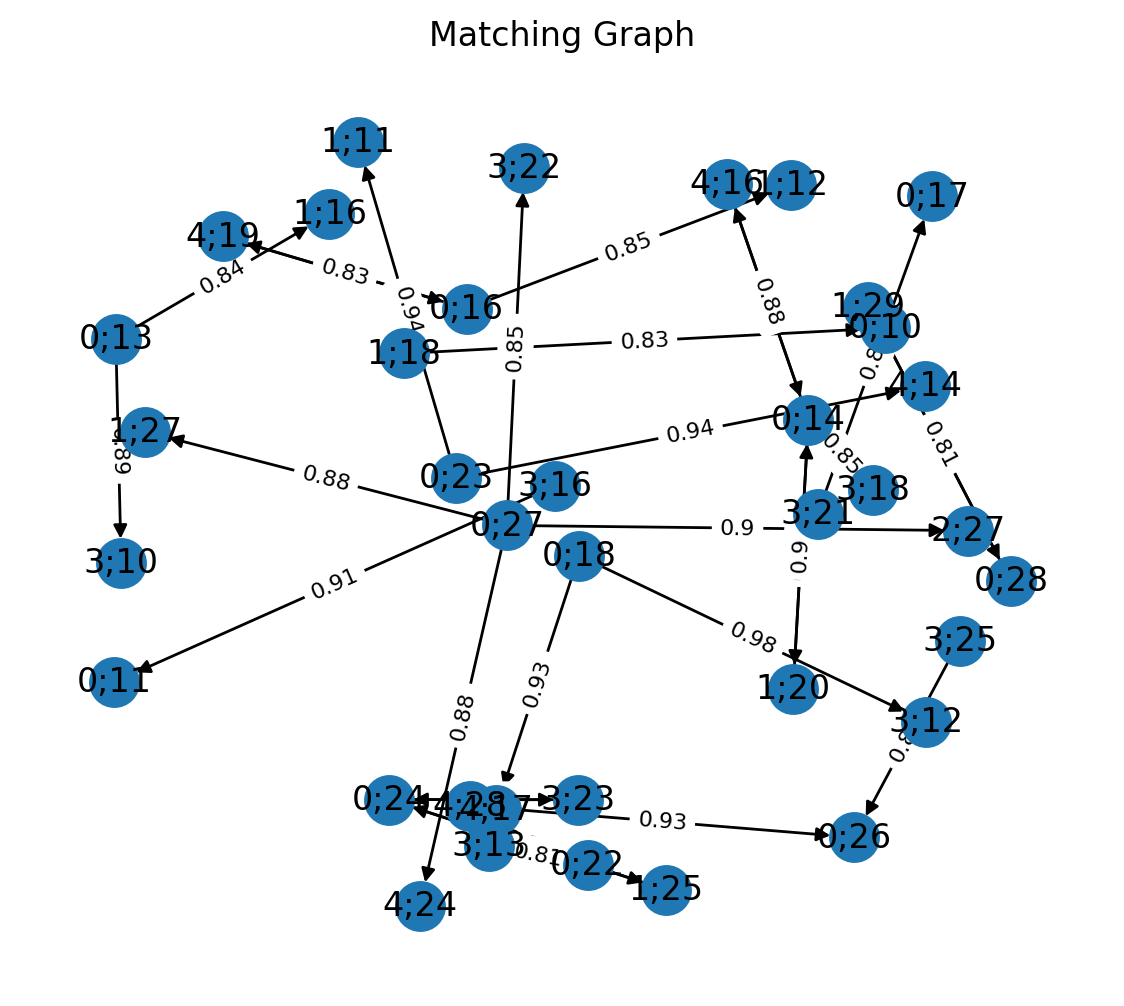

In [707]:
draw_G(G_bigger_range, k=0.5, iterations=30, seed=7)

Let's select $(0;23)$ and $(0;18)$ from this graph, that are both connected to two other nodes

In [697]:
interesting_clusters = [
    Cluster(characters, us_movies, communities_US_list[0][23]),
    Cluster(characters, us_movies, communities_US_list[0][18]),
]

Now let's look at top-10 higest-grossing movies in which at least $50\%$ of the cluster participated in.

In [698]:
def get_top_movies_by_revenue(cluster):
    return cluster.cluster_movies(select_type="half", num_actors_in_movie=us_num_actors_in_movie).sort_values(by="Revenue", ascending=False)["MovieName"].head(10)

In [699]:
get_top_movies_by_revenue(interesting_clusters[0])

73924                         The Santa Clause
24838                       The Santa Clause 2
22501    The Santa Clause 3: The Escape Clause
47410                             The Good Son
42282        American Pie Presents: Beta House
74625                                     Zoom
32270                                     Prom
73990                            Away From Her
6618                              How She Move
Name: MovieName, dtype: object

In [700]:
get_top_movies_by_revenue(interesting_clusters[1])

19034                The Incredibles
69086                      Cast Away
51157    Sex and the City: The Movie
76332         The Mothman Prophecies
32108    Mortal Kombat: Annihilation
34648                    Soul Surfer
18853                Winnie the Pooh
40755            Ernest Goes to Jail
5517                  Country Strong
51009           Ernest Scared Stupid
Name: MovieName, dtype: object

In [704]:
from src.utils.q_4_5.helpers import print_cluster_actor_info

for i in range(len(interesting_clusters)):
    print_cluster_actor_info(G_US, characters, us_movies, interesting_clusters[i])
    print()

Wendy Crewson has centrality: 1.000
Tim Allen has centrality: 0.639
Cameron Monaghan has centrality: 0.635
Nina Dobrev has centrality: 0.628
Eric Lloyd has centrality: 0.627

Craig T. Nelson has centrality: 1.000
Helen Hunt has centrality: 0.788
Kevin Sorbo has centrality: 0.639
Lari White has centrality: 0.497
John Philbin has centrality: 0.489



Wendy Crewson is actually important to the community, because she played in all of the Santa Clause movies and The Good Son, the $4$ most grossing movies of the cluster

Craig T. Nelson played only in the The Incredibles from the 10 most grossing films

So we can see that the actors that are important (or central) for the graph can both play a lot or almost not play in the most grossing movies of the cluster